# Richter's Predictor: Modeling Earthquake Damage

Based on aspects of building location and construction, your goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal.

### Libraries

In [1]:
# Data exploration and manipulation essentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistic tests
# from scipy import stats
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize

# Classification Models
import statsmodels.formula.api as smf
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
# from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

# Cross-validation
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import make_scorer  

# Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from statistics import stdev
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

### Importing Data

In [2]:
# training data
train_values_raw = pd.read_csv('data/train_values.csv')
train_labels = pd.read_csv('data/train_labels.csv')

# testing data
test_values_raw = pd.read_csv('data/test_values.csv')

In [3]:
train_values = train_values_raw.drop('building_id', axis=1)
test_values = test_values_raw.drop('building_id', axis=1)

### Creating Numeric and Categorical Lists

In [4]:
columns = train_values.columns

for i in columns:
    if len(train_values[i].unique()) == 2:
        train_values[i] = train_values[i].astype('category')

In [5]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   geo_level_1_id                          260601 non-null  int64   
 1   geo_level_2_id                          260601 non-null  int64   
 2   geo_level_3_id                          260601 non-null  int64   
 3   count_floors_pre_eq                     260601 non-null  int64   
 4   age                                     260601 non-null  int64   
 5   area_percentage                         260601 non-null  int64   
 6   height_percentage                       260601 non-null  int64   
 7   land_surface_condition                  260601 non-null  object  
 8   foundation_type                         260601 non-null  object  
 9   roof_type                               260601 non-null  object  
 10  ground_floor_type               

In [6]:
# numeric data frame
numeric_train = train_values.select_dtypes(include=[int, float])

numeric_cols = list(numeric_train.columns)

numeric_test = test_values[numeric_cols]

# categorical data frame
categorical_train = train_values.select_dtypes(exclude=[int, float])

categorical_cols = list(categorical_train.columns)

categorical_test = test_values[categorical_cols]

In [7]:
print(numeric_cols, '\n-----------------------\n', categorical_cols)

['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families'] 
-----------------------
 ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_us

In [8]:
numeric_train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
0,6,487,12198,2,30,6,5,1
1,8,900,2812,2,10,8,7,1
2,21,363,8973,2,10,5,5,1
3,22,418,10694,2,10,6,5,1
4,11,131,1488,3,30,8,9,1


In [9]:
numeric_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
0,17,596,11307,3,20,7,6,1
1,6,141,11987,2,25,13,5,1
2,22,19,10044,2,5,4,5,1
3,26,39,633,1,0,19,3,2
4,17,289,7970,3,15,8,7,1


### Train-Test split the Training Set

In [10]:
X = train_values
y = train_labels.drop('building_id', axis=1).values.ravel() # to convert to a 1-d numpy array

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

### Feature Scaling Numeric Columns

In [12]:
# scaling the numeric columns
Standard_Scaler = StandardScaler()

In [13]:
# sub training and testing data
xtrain_scaled = Standard_Scaler.fit_transform(xtrain[numeric_cols])
xtest_scaled = Standard_Scaler.transform(xtest[numeric_cols])

xtrain[numeric_cols] = xtrain_scaled
xtest[numeric_cols] = xtest_scaled

In [14]:
# full training and testing data
train_scaled = Standard_Scaler.fit_transform(X[numeric_cols])
X[numeric_cols] = train_scaled

test_scaled = Standard_Scaler.fit_transform(test_values[numeric_cols])
test_values[numeric_cols] = test_scaled

### Feature Scaling Categorical Columns

In [15]:
# one-hot encoding the columns that are not yet numerical
not_yet_numeric = categorical_train.select_dtypes(exclude=['category'])
not_yet_numeric_cols = not_yet_numeric.columns

In [16]:
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), 
     ['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status']))

Sub-Training Set

In [17]:
transformed_xtrain = transformer.fit_transform(xtrain)
dense_array = transformed_xtrain.toarray()
transformed_df = pd.DataFrame(dense_array, columns = transformer.get_feature_names_out())
transformed_df.index = xtrain.index

# Joining tables
xtrain = pd.concat([xtrain, transformed_df], axis=1)
# Dropping old categorical columns
xtrain.drop(not_yet_numeric_cols, axis=1, inplace=True)

In [18]:
xtrain = xtrain.reset_index(drop=True)
xtrain.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,onehotencoder__plan_configuration_m,onehotencoder__plan_configuration_n,onehotencoder__plan_configuration_o,onehotencoder__plan_configuration_q,onehotencoder__plan_configuration_s,onehotencoder__plan_configuration_u,onehotencoder__legal_ownership_status_a,onehotencoder__legal_ownership_status_r,onehotencoder__legal_ownership_status_v,onehotencoder__legal_ownership_status_w
0,-0.734245,0.306735,0.770372,1.198079,-0.225337,-0.003630,1.862323,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.232181,-1.349505,1.693148,-0.178324,-0.293740,-0.003630,-0.747645,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.232181,-0.415900,1.178634,-0.178324,0.116680,-0.232414,-0.747645,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.386112,-0.510473,0.448870,-0.178324,0.527099,-0.461199,-0.747645,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.381986,1.618631,-0.113692,-0.178324,-0.293740,-0.461199,-0.225652,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Sub-Testing Set

In [19]:
transformed_xtest = transformer.transform(xtest)
dense_array = transformed_xtest.toarray()
transformed_df = pd.DataFrame(dense_array, columns = transformer.get_feature_names_out())
transformed_df.index = xtest.index

# Joining tables
xtest = pd.concat([xtest, transformed_df], axis=1)
# Dropping old categorical columns
xtest.drop(not_yet_numeric_cols, axis=1, inplace=True)

In [20]:
xtest = xtest.reset_index(drop=True)
xtest.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,onehotencoder__plan_configuration_m,onehotencoder__plan_configuration_n,onehotencoder__plan_configuration_o,onehotencoder__plan_configuration_q,onehotencoder__plan_configuration_s,onehotencoder__plan_configuration_u,onehotencoder__legal_ownership_status_a,onehotencoder__legal_ownership_status_r,onehotencoder__legal_ownership_status_v,onehotencoder__legal_ownership_status_w
0,0.012660,1.616206,-0.296270,1.198079,0.253486,-0.689984,0.296342,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.983213,0.105464,-0.140872,-0.178324,-0.225337,-0.232414,-0.225652,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.360792,0.156388,-1.532861,2.574482,0.321889,-0.003630,1.862323,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.605634,-1.019712,0.007112,-0.178324,0.185083,0.225155,-0.225652,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.858729,-0.352851,-0.371223,-1.554727,-0.293740,-1.147554,-1.791633,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Full Training Data

In [21]:
transformed_X = transformer.fit_transform(X)
dense_array = transformed_X.toarray()
transformed_df = pd.DataFrame(dense_array, columns = transformer.get_feature_names_out())
transformed_df.index = X.index

# Joining tables
X_scaled = pd.concat([X, transformed_df], axis=1)
# Dropping old categorical columns
X_scaled.drop(not_yet_numeric_cols, axis=1, inplace=True)

In [22]:
X_scaled = X_scaled.reset_index(drop=True)
X_scaled.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,onehotencoder__plan_configuration_m,onehotencoder__plan_configuration_n,onehotencoder__plan_configuration_o,onehotencoder__plan_configuration_q,onehotencoder__plan_configuration_s,onehotencoder__plan_configuration_u,onehotencoder__legal_ownership_status_a,onehotencoder__legal_ownership_status_r,onehotencoder__legal_ownership_status_v,onehotencoder__legal_ownership_status_w
0,-0.983414,-0.518705,1.629055,-0.178274,0.047100,-0.459460,-0.226419,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.734459,0.481998,-0.945017,-0.178274,-0.224765,-0.004110,0.816109,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.883744,-0.819158,0.744612,-0.178274,-0.224765,-0.687135,-0.226419,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.008221,-0.685893,1.216589,-0.178274,-0.224765,-0.459460,-0.226419,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.361028,-1.381296,-1.308119,1.195989,0.047100,-0.004110,1.858636,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Full Testing Data

In [23]:
transformed_test = transformer.transform(test_values)
dense_array = transformed_test.toarray()
transformed_df = pd.DataFrame(dense_array, columns = transformer.get_feature_names_out())
transformed_df.index = test_values.index

# Joining tables
X_test_scaled = pd.concat([test_values, transformed_df], axis=1)
# Dropping old categorical columns
X_test_scaled.drop(not_yet_numeric_cols, axis=1, inplace=True)

In [24]:
X_test_scaled = X_test_scaled.reset_index(drop=True)
X_test_scaled.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,onehotencoder__plan_configuration_m,onehotencoder__plan_configuration_n,onehotencoder__plan_configuration_o,onehotencoder__plan_configuration_q,onehotencoder__plan_configuration_s,onehotencoder__plan_configuration_u,onehotencoder__legal_ownership_status_a,onehotencoder__legal_ownership_status_r,onehotencoder__legal_ownership_status_v,onehotencoder__legal_ownership_status_w
0,0.387545,-0.261582,1.382754,1.190666,-0.089223,-0.231598,0.295710,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.982399,-1.362313,1.569122,-0.182880,-0.021116,1.138930,-0.228690,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.010246,-1.657455,1.036602,-0.182880,-0.293547,-0.916862,-0.228690,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.508407,-1.609071,-1.542679,-1.556426,-0.361655,2.509459,-1.277491,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.387545,-1.004273,0.468179,1.190666,-0.157331,-0.003176,0.820111,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Change Dtype back to Integer

In [25]:
def change_dtype(dataset):
    for col in dataset.columns:
        if dataset[col].dtype != float:
            dataset[col] = dataset[col].astype(int)

In [26]:
dataframes = [xtrain, xtest, X_scaled, X_test_scaled]

for i in dataframes:
    change_dtype(i)

In [27]:
for i in dataframes:
    print(i.dtypes.unique())

[dtype('float64') dtype('int64')]
[dtype('float64') dtype('int64')]
[dtype('float64') dtype('int64')]
[dtype('float64') dtype('int64')]


### Model Building

In [28]:
# Level 0
estimators = []
estimators.append(('AdaBoostClassifier', AdaBoostClassifier(random_state=13, algorithm = 'SAMME')))
estimators.append(('Gradient Boosting Classifier', GradientBoostingClassifier(n_estimators=100, random_state=13)))
estimators.append(('Hist Gradient Boosting Classifier', HistGradientBoostingClassifier(random_state=13)))
estimators.append(('OvO', OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state=13))))
estimators.append(('OvR', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=13))))
estimators.append(('RandomForest', RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=3, n_estimators=100, random_state=13)))
# estimators.append(('XGB', XGBClassifier(random_state=13)))
# estimators.append(('CatBoost', CatBoostClassifier(logging_level='Silent', random_state=13)))
# estimators.append(('SVC', SVC(random_state=13)))

In [29]:
print(estimators)

[('AdaBoostClassifier', AdaBoostClassifier(algorithm='SAMME', random_state=13)), ('Gradient Boosting Classifier', GradientBoostingClassifier(random_state=13)), ('Hist Gradient Boosting Classifier', HistGradientBoostingClassifier(random_state=13)), ('OvO', OneVsOneClassifier(estimator=LogisticRegression(max_iter=1000, random_state=13))), ('OvR', OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 random_state=13))), ('RandomForest', RandomForestClassifier(max_depth=10, min_samples_split=3, random_state=13)), ('SVC', SVC(random_state=13))]


In [30]:
# Level 1
# HGB = HistGradientBoostingClassifier(random_state=13)
XGB = XGBClassifier(booster = 'gbtree',
                    n_estimators = 900, 
                    subsample = 0.8,
                    min_child_weight = 6,
                    max_depth = 11,
                    eta = 0.025,
                    colsample_bytree = 0.7,
                    verbosity = 1,
                    gamma = 0.9,
                    eval_metric = 'auc',
                    random_state = 13,
                    objective = 'multi:softmax',
                    n_jobs = -1)

In [31]:
# Stacking Classifier
SC = StackingClassifier(estimators = estimators, final_estimator = XGB, cv = 6)
SC.fit(xtrain, ytrain)

In [ ]:
y_pred = SC.predict(xtest)

print(f"\nStacking classifier training Accuracy: {SC.score(xtrain, ytrain):0.2f}")
print(f"Stacking classifier test Accuracy: {SC.score(xtest, ytest):0.2f}")


Stacking classifier training Accuracy: 0.74
Stacking classifier test Accuracy: 0.72


In [ ]:
# SC_Recall = recall_score(ytest, y_pred)
# SC_Precision = precision_score(ytest, y_pred)
y_pred_proba = SC.predict_proba(xtest)
y_test_bin = label_binarize(ytest, classes = np.unique(ytest))

SC_f1 = f1_score(ytest, y_pred, average='micro')
SC_accuracy = accuracy_score(ytest, y_pred)
SC_roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovo')

cm = confusion_matrix(ytest, y_pred)

print(SC_f1)
print(SC_accuracy)
print(SC_roc_auc)
print(cm)

0.7196761361456109
0.7196761361456109
0.8500253806183174
[[ 3486  3956    95]
 [ 1567 37281  5630]
 [  131 10537 15498]]


In [ ]:
score = cross_val_score(SC, xtrain, ytrain, cv=StratifiedKFold(n_splits = 5), scoring='f1_micro', error_score="raise", verbose = 100)
SC_cv_score = score.mean()
SC_cv_stdev = stdev(score)

In [ ]:
print('Cross Validation ROC AUC scores are: {}'.format(score))
print('Average Cross Validation ROC AUC score: ', SC_cv_score)
print('Cross Validation ROC AUC standard deviation: ', SC_cv_stdev)

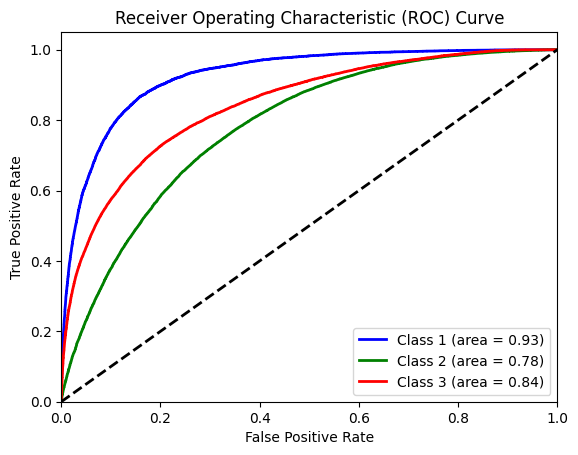

In [ ]:
# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Binarize the target
y_bin = label_binarize(y, classes= np.unique(y))
n_classes = y_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i + 1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Final Predictions

In [ ]:
# Stacking Classifier
SC = StackingClassifier(estimators = estimators, final_estimator = XGB, cv = 6)
SC.fit(X_scaled, y)
y_pred = SC.predict(X_test_scaled)

In [ ]:
submission = pd.DataFrame({
    'building_id' : test_values_raw['building_id'],
    'damage_grade' : y_pred
})

In [ ]:
submission.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3


In [ ]:
submission.to_csv('submission/submission.csv', index=False)